<a href="https://colab.research.google.com/github/peppefdf/CSL_Gipuzkoa/blob/main/Aggregate_by_LatLon_coords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aggregated points based on distance:
       Lat    Lon                   geometry  A
0  43.1600 -2.190  POINT (-2.19000 43.16000)  1
1  43.1910 -2.190  POINT (-2.19000 43.19100)  2
2  43.2045 -2.345  POINT (-2.34500 43.20450)  3
3  43.2050 -2.305  POINT (-2.30500 43.20500)  1
4  43.2345 -2.341  POINT (-2.34100 43.23450)  1
5  43.2480 -2.364  POINT (-2.36400 43.24800)  2
6  43.2520 -2.234  POINT (-2.23400 43.25200)  3
7  43.2540 -2.254  POINT (-2.25400 43.25400)  2


<ipython-input-120-efd5f5ff0ed4>:33: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist_matrix = zones.geometry.apply(lambda g: zones.distance(g))


Distance matrix:
          0         1         2         3         4         5         6  \
0  0.000000  0.031000  0.161261  0.123491  0.168378  0.194987  0.101980   
1  0.031000  0.000000  0.155587  0.115849  0.157141  0.183098  0.075213   
2  0.161261  0.155587  0.000000  0.040003  0.030265  0.047468  0.120736   
3  0.123491  0.115849  0.040003  0.000000  0.046543  0.073007  0.085147   
4  0.168378  0.157141  0.030265  0.046543  0.000000  0.026669  0.108422   
5  0.194987  0.183098  0.047468  0.073007  0.026669  0.000000  0.130062   
6  0.101980  0.075213  0.120736  0.085147  0.108422  0.130062  0.000000   
7  0.113719  0.089805  0.103592  0.070725  0.089159  0.110164  0.020100   

          7  
0  0.113719  
1  0.089805  
2  0.103592  
3  0.070725  
4  0.089159  
5  0.110164  
6  0.020100  
7  0.000000  
The original list is :  [array([0, 0]), array([0, 1]), array([1, 0]), array([1, 1]), array([2, 2]), array([2, 3]), array([2, 4]), array([2, 5]), array([3, 2]), array([3, 3]), array(

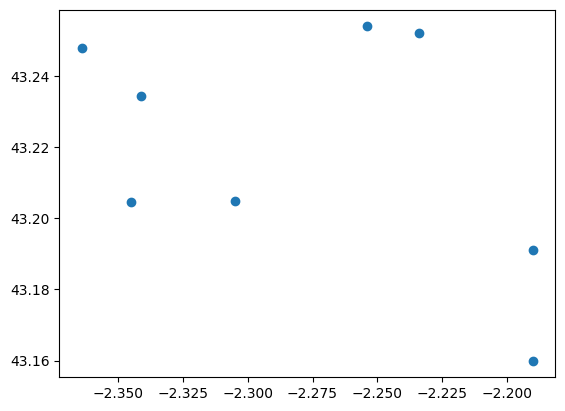

In [120]:
#%pip install geodatasets
#%pip install pointpats
#%pip install mapclassify

import pandas as pd
import geopy.distance
import numpy as np
import geopandas
import scipy

import folium
import matplotlib
from matplotlib import cm

from collections import defaultdict
from collections import Counter

tol = 0.05 # <-- very case-specific

d = {'A': [1, 2, 3, 3, 2, 2, 1, 1], 'Lat': [43.2345, 43.248, 43.252, 43.2045, 43.254, 43.191, 43.205, 43.160], 'Lon': [-2.341, -2.364, -2.234, -2.345, -2.254, -2.19, -2.305, -2.19]}
df = pd.DataFrame(data=d)

gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.Lon, df.Lat), crs="EPSG:4326")

#zones = gdf.dissolve(by=['Lat','Lon'], aggfunc={"A": list})
zones = gdf.dissolve(by=['Lat','Lon'], as_index=False)

zones.plot();
print('Aggregated points based on distance:')
print(zones)

dist_matrix = zones.geometry.apply(lambda g: zones.distance(g))
print('Distance matrix:')
print(dist_matrix)
dist_matrix = np.array(dist_matrix)
# Carefull!! 0.12 is arbitrary!
list_el = np.argwhere(dist_matrix < tol)
print("The original list is : ", list(list_el))

# Record Similar tuple occurrences
# Using Counter() + map() + sorted
res = dict(Counter(tuple(ele) for ele in map(sorted, list_el)))

# printing result
print("The frequency of like tuples : " + str(res))

res = list(res.keys())
res = [res[i] for i in range(len(res)) if res[i][0]!=res[i][1]]
print('Diag. elements removed:', res)


def dfs(adj_list, visited, vertex, result, key):
    visited.add(vertex)
    result[key].append(vertex)
    for neighbor in adj_list[vertex]:
        if neighbor not in visited:
            dfs(adj_list, visited, neighbor, result, key)

adj_list = defaultdict(list)
for x, y in res:
    adj_list[x].append(y)
    adj_list[y].append(x)

result = defaultdict(list)
visited = set()
for vertex in adj_list:
    if vertex not in visited:
        dfs(adj_list, visited, vertex, result, vertex)

groups = result.values()

indexes = list(result.values())
zones["Group"] = ""
zones["color"] = ""
group = 0
n_colors = len(indexes)
cmap = cm.rainbow(np.linspace(0, 1, n_colors))

for i in indexes:
   print('Group ',group, ' :',i)
   zones.loc[i,'Group'] = group
   zones.loc[i,'color'] = matplotlib.colors.rgb2hex(cmap[group])
   group+=1

print(zones)

mapPlot = folium.Map(location=[43.23450, -2.34100], zoom_start=12)
for lon, lat, c in zip(zones['Lon'], zones['Lat'], zones['color']):
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        fill_color=c,
        color = c,
        fill=True,
        fill_opacity=0.7
        ).add_to(mapPlot)
mapPlot

